In [1]:
import pandas as pd
from pymongo import MongoClient
import plotly.express as px
from datetime import datetime
from dateutil.relativedelta import relativedelta

def _connect_mongo(host, port, username, password, db):
    """ A util for making a connection to mongo """

    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)


    return conn[db]

db = _connect_mongo(host='localhost', port=27017, username=None, password=None, db='OpenRoadDB')

KPI = db.kpi
ENGINE = db.engine_history

output_path = '/Users/rajiv/Development/iora/python/openroad/ride_hailing/apps/output'


# run_id_meta = {
#     # # 'FIQgwybgpIv6': 'Random old',
#     # # '8X6m0Rkz5G1W': 'Greedy Pickup old',
#     # # '6roQmPCm6O9N': 'Greedy Revenue old',
#     # # 'w67ZLPpg4V27': 'Greedy Service old',
#     # '': 'Random 2',
#     # '': 'Greedy Pickup 2',
#     # '': 'Greedy Revenue 2',
#     '5IORM3YrHlwR': 'Greedy Service 2',
# #     '': 'Compromise',
# }



In [18]:
from datetime import date, datetime, tzinfo, timezone
from pymongo.cursor import CursorType


def get_paths_from_cursor(collection, args, filter):

    # print(args)
    _from = args.get('from')
    from_dt = datetime.strptime(_from, '%Y%m%d%H%M%S').replace(tzinfo=timezone.utc)
    _to = args.get('to')
    to_dt = datetime.strptime(_to, '%Y%m%d%H%M%S').replace(tzinfo=timezone.utc)

    filter["sim_clock"] = {
        "$gte": from_dt,
        "$lt": to_dt
    }
    # print(filter)
    project = {
        '_id': 0,
        "event.state": 1,
        "event.location.coordinates": 1,
        "event.traversed_path": 1,
        "trip": 1,
        "sim_clock": 1,
    }
    sort=list({
        'trip': 1,
        'counter': 1
    }.items())

    cursor = collection.find(
        filter=filter,
        projection=project,
        sort=sort,
        cursor_type=CursorType.EXHAUST
    )

    trip = {
        'trip_id': None,
        'tripclass': None,
        'path': [],
        'traversed_path': [],
        'timestamps': [],
    }
    paths = []
    for document in cursor:
        trip_id = str(document['trip'])
        coord = [round(x, 5) for x in document['event']['location']['coordinates']]
        traversed_path = document['event'].get('traversed_path') \
                            if document['event'].get('traversed_path') is not None \
                            else []
        tripclass = document['event']['state']
        ts = document['sim_clock'].replace(tzinfo=timezone.utc)

        if trip['trip_id'] is None:
            trip = {
                'trip_id': trip_id,
                'tripclass': tripclass,
                'path': [coord],
                'traversed_path': traversed_path,
                'timestamps': [(ts-from_dt).seconds],
            }
        elif (trip['trip_id'] == trip_id) and (trip['tripclass'] == tripclass):
            trip['path'].append(coord)
            trip['traversed_path'].extend(traversed_path)
            trip['timestamps'].append((ts-from_dt).seconds)
        else:
            if len(trip['path']) > 1:
                paths.append(trip)
            trip = {
                'trip_id': trip_id,
                'tripclass': tripclass,
                'path': [coord],
                'traversed_path': traversed_path,
                'timestamps': [(ts-from_dt).seconds],
            }

    return paths


In [19]:
import json
WAYPOINT = db.waypoint

filter = {
    'run_id': 'iWuf33bxKkzv',
}

for t in range(8, 16):
    args = {
        'from': f"20200101{t:02}0000",
        'to': f"20200101{t+1:02}0000"
    }

    paths = get_paths_from_cursor(WAYPOINT, args, filter)

    with open(f"{output_path}/{filter['run_id']}/paths_{args['from']}_{args['to']}.json", 'w') as file:
        json.dump(paths, file, indent=2)
    
    

FileNotFoundError: [Errno 2] No such file or directory: '/Users/rajiv/Development/iora/python/openroad/ride_hailing/apps/output/iWuf33bxKkzv/paths_20200101080000_20200101090000.json'

In [46]:
def get_pivot(collection, run_id_meta, metric):
    cursor = collection.find({
            'run_id': {'$in': [k for k, _ in run_id_meta.items()]},
            'metric': metric
        },
        projection={ '_id': 0, 'run_id': 1, 'sim_clock': 1, 'value': 1,},
        sort=[('sim_clock', 1)]
    )

    metric_df = pd.DataFrame(list(cursor))

    metric_pivot = pd.pivot_table(metric_df, 
                                  index='sim_clock', 
                                  columns='run_id', 
                                  values='value').rename(columns=run_id_meta)
    cumulative_pivot = metric_pivot.cumsum()

    metric_pivot_by_time = cumulative_pivot.copy()
    metric_pivot_by_time['time_step'] = list(range(1, len(cumulative_pivot)+1))
    metric_pivot_by_time['value'] = metric_pivot_by_time['value'] / metric_pivot_by_time['time_step']

    
    # print(metric_pivot_by_time)

    return metric_pivot_by_time, cumulative_pivot




In [51]:
pivot, cum_pivot = get_pivot(KPI, {'JLpdE5GzvX1b': 'value'}, 'wait_time_pickup')

cum_pivot['sim_clock'] = cum_pivot.index.strftime('%H:%M:%S')
cum_pivot.to_dict(orient='records')
cum_pivot.values.tolist()



[[0.0, '04:00:00'],
 [0.0, '04:00:30'],
 [0.0, '04:01:00'],
 [0.0, '04:01:30'],
 [0.0, '04:02:00'],
 [0.0, '04:02:30'],
 [0.0, '04:03:00'],
 [0.0, '04:03:30'],
 [0.0, '04:04:00'],
 [0.0, '04:04:30'],
 [0.0, '04:05:00'],
 [0.0, '04:05:30'],
 [0.0, '04:06:00'],
 [0.0, '04:06:30'],
 [0.0, '04:07:00'],
 [0.0, '04:07:30'],
 [0.0, '04:08:00'],
 [0.0, '04:08:30'],
 [0.0, '04:09:00'],
 [0.0, '04:09:30'],
 [0.0, '04:10:00'],
 [540.0, '04:10:30'],
 [540.0, '04:11:00'],
 [540.0, '04:11:30'],
 [540.0, '04:12:00'],
 [870.0, '04:12:30'],
 [870.0, '04:13:00'],
 [1230.0, '04:13:30'],
 [1230.0, '04:14:00'],
 [1230.0, '04:14:30'],
 [1230.0, '04:15:00'],
 [1230.0, '04:15:30'],
 [1230.0, '04:16:00'],
 [1230.0, '04:16:30'],
 [1230.0, '04:17:00'],
 [1230.0, '04:17:30'],
 [1230.0, '04:18:00'],
 [2100.0, '04:18:30'],
 [2580.0, '04:19:00'],
 [2580.0, '04:19:30'],
 [2580.0, '04:20:00'],
 [2580.0, '04:20:30'],
 [2580.0, '04:21:00'],
 [2580.0, '04:21:30'],
 [3030.0, '04:22:00'],
 [3030.0, '04:22:30'],
 [3030.0, '

In [21]:
KPI = db.kpi

sum_metric = [
    'served', 
    'cancelled',
    'revenue', 
    'wait_time_pickup',
    'service_score'
]
avg_metric_byServed = [
    'revenue',
    'wait_time_pickup',
    'service_score',
]
# avg_metric_byAccepted = [
#     'service_score'
# ]


In [20]:

run_id_meta = {
    filter['run_id']: 'value',
}
for m in sum_metric:
    metric_pivot, cum_pivot = get_pivot(KPI, run_id_meta, m)
    cum_pivot['sim_clock'] = metric_pivot.index

    metrics = cum_pivot.to_dict(orient='records')

    with open (f"{output_path}/{filter['run_id']}/plot_cumulative_{m}.json", 'w') as file:
        json.dump(metrics, file, default=str, indent=2)

served_pivot, served_cum_pivot = get_pivot(KPI, run_id_meta, 'served')
for m in avg_metric_byServed:
    metric_pivot, cum_pivot = get_pivot(KPI, run_id_meta, m)
    metric_pivot = metric_pivot / served_pivot
    cum_pivot = cum_pivot / served_cum_pivot
    
    metric_pivot['sim_clock'] = metric_pivot.index 
    cum_pivot['sim_clock'] = cum_pivot.index

    metrics = cum_pivot.to_dict(orient='records')

    with open (f"{output_path}/{filter['run_id']}/plot_avg_{m}_by_served.json", 'w') as file:
        json.dump(metrics, file, default=str, indent=2)

        

# num_accepted_pivot = get_cumulative_pivot(KPI, run_id_meta, 'num_accepted')
# for m in avg_metric_byAccepted:
#     metric_pivot = get_cumulative_pivot(KPI, run_id_meta, m) / num_accepted_pivot
#     metric_pivot['sim_clock'] = metric_pivot.index

#     metrics = metric_pivot.to_dict(orient='records')

#     with open (f"plot_avg_{m}_by_accepted.json", 'w') as file:
#         json.dump(metrics, file, default=str, indent=2)

        

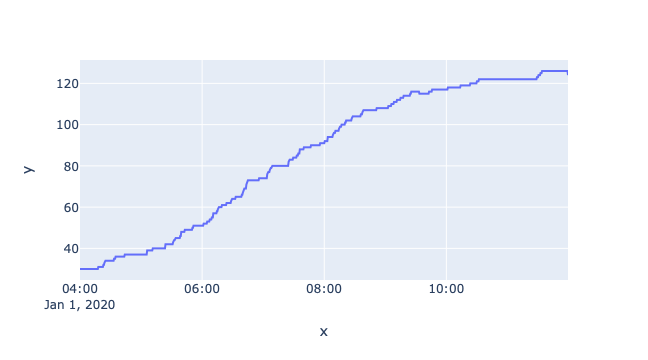

In [15]:
DRIVER_TRIP = db.driver_ride_hail_trip


cursor = DRIVER_TRIP.aggregate([
    {
        '$match': {
            'run_id': 'r0kZnIvJqUWg'
        }
    }, {
        '$group': {
            '_id': {
                'user': '$user'
            }, 
            'entered_market': {
                '$min': '$_created'
            }, 
            'exit_market': {
                '$max': '$_updated'
            }
        }
    }
])

docs = list(cursor)
start_time = datetime(2020, 1, 1, 4, 0)
end_time = datetime(2020, 1, 1, 12, 0)

results = []

for elapsed_time in range(0, int((end_time-start_time).total_seconds()), 30):
    sim_clock = start_time + relativedelta(seconds=elapsed_time)
    value = 0
    for doc in docs:
        if (doc['entered_market'] <= sim_clock) and (doc['exit_market'] >= sim_clock):
            value += 1
    
    results.append({
        "sim_clock": sim_clock,
        "value": value
    })

px.line(x=[item['sim_clock'] for item in results], y=[item['value'] for item in results])



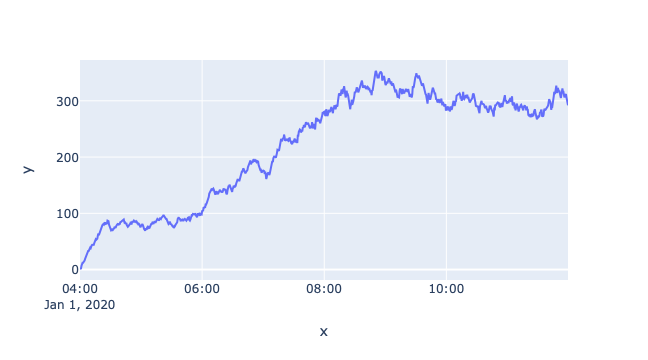

In [16]:

PASSENGER_TRIP = db.passenger_ride_hail_trip


cursor = PASSENGER_TRIP.aggregate([
    {
        '$match': {
            'run_id': 'r0kZnIvJqUWg'
        }
    }, {
        '$group': {
            '_id': {
                'user': '$user'
            }, 
            'entered_market': {
                '$min': '$_created'
            }, 
            'exit_market': {
                '$max': '$_updated'
            }
        }
    }
])

docs = list(cursor)
start_time = datetime(2020, 1, 1, 4, 0)
end_time = datetime(2020, 1, 1, 12, 0)

results = []

for elapsed_time in range(0, int((end_time-start_time).total_seconds()), 30):
    sim_clock = start_time + relativedelta(seconds=elapsed_time)
    value = 0
    for doc in docs:
        if (doc['entered_market'] <= sim_clock) and (doc['exit_market'] >= sim_clock):
            value += 1
    
    results.append({
        "sim_clock": sim_clock,
        "value": value
    })

px.line(x=[item['sim_clock'] for item in results], y=[item['value'] for item in results])


